In [1]:
# import standard modules and DCTR
import sys
import numpy as np
import math
import tensorflow as tf

# import DCTR
path_to_DCTR = '/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/' # modify as needed
sys.path.append(path_to_DCTR)
import DCTR

# make sure GPU usage is enabled
print(tf.config.list_physical_devices('GPU'))


2023-11-27 11:08:38.959754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-27 11:08:38.959778: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


ModuleNotFoundError: No module named 'DCTR'

In [17]:
from importlib import reload
reload(DCTR)


<module 'DCTR' from '/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py'>

In [ ]:
# TODO: 

# use new POWHEG events (when available)

# compare with: only using top anti-top (no tt-pair)
# compare with: removing energy from inputs (only [pt, phi, y, mass, PID])
                                          # (only fourMomentum + PID)

# jet particles:
    # Use only first Jet Particle to train
    # combine NNLO jet parts
    # split NLO jet into 2 with QCD splitting functions
    
        # pt and delta phi most interesting


# load data

In [2]:
# Load Datasets: MiNNLO: X1 | POWHEG hvq: X0
# all particles arrays

X0_test = []
# POWHEG hvq
# args: filePath, i=number of particles to load
X0_test = DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/POWHEG_hvq/converted_lhe.npz', i=3)
print('POWHEG hvq X0_test.shape: '+str(X0_test.shape))

X1_test = []
# MiNNLO
X1_test = DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/converted_lhe.npz', i=3) # i=number of particles to load
print('MiNNLO     X1_test.shape: '+str(X1_test.shape))


POWHEG hvq X0_test.shape: (29605180, 3, 9)
MiNNLO     X1_test.shape: (9553938, 3, 9)


In [3]:
# Load pre-normed Datasets: MiNNLO: X1 | POWHEG hvq: X0
# only contain tt-pair every event has order: 
# tt-pair, top, anti-top

# every particle has arguments: 
# [pt, rapidity, phi, mass, eta, E, PID, w, theta]
# [0 , 1       , 2  , 3   , 4  , 5, 6  , 7, 8    ]


X0_nrm = []
X1_nrm = []

# POWHEG hvq
X0_nrm = DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/POWHEG_hvq/normed_lhe.npz')
print('POWHEG hvq all particles X0.shape: '+str(X0_nrm.shape))

# MiNNLO
X1_nrm = DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/normed_lhe.npz')
print('MiNNLO all particles X1.shape: '+str(X1_nrm.shape))


POWHEG hvq all particles X0.shape: (29605180, 3, 9)
MiNNLO all particles X1.shape: (9553938, 3, 9)


In [4]:
# delete eta (pseudorpaidity) because neural network was too good at classifiying
X0_nrm = np.delete(X0_nrm, 4, -1)
X1_nrm = np.delete(X1_nrm, 4, -1)


In [5]:
# get normalized event generator weights
X0_nrm_wgt = X0_nrm[:, 0, 6].copy() # would be arg 7, but we removed eta above
X1_nrm_wgt = X1_nrm[:, 0, 6].copy()


# prep data for training

In [ ]:
''' # turning this off, since weights are prop to likelihood ratio, since we're normalizing weights (so mean is 1) prop-factor should be irrelevant
# create training datasets
# POWHEG has many more events than MiNNLO -> use multiple copies of MiNNLO (two b/c RAM limitations)
# trim_datasets(X, Y, shuffle=False) returns the two arrays trimmed to the length of the shorter of the two
# if shuffle =+ True: uses np.rng to shuffle order of events
X0, X1 = DCTR.trim_datasets(X0_nrm, np.concatenate((X1_nrm, X1_nrm)))

print('POWHEG hvq all particles X0.shape: '+str(X0.shape))
print('MiNNLO all particles X1.shape: '+str(X1.shape))
'''

In [9]:
# prep arrays for the neural network

# prep_arrays() necessary args:
# X0, X1
# prep_arrays() default args:
# val=0.15, shuffle=True, use_class_weights=False

# strips theta parameter from datasets and creates Y classifier arrays
# strips wgts from datasets and creates wgt arrays | if use_class_weights==True: -> give over represented dataset smaller weights 
# splits arrays into training and validation datasets accroding to val
# splits arrays into training and validation datasets accroding to val

X_train, X_val, Y_train, Y_val, wgt_train, wgt_val = DCTR.prep_arrays(X0_nrm, X1_nrm, val=0.2)



# train DCTR neural network

In [56]:
# setup neural positive reweigher
# default setup_nn() args:
# input_dim=7, Phi_sizes = (100,100,128), F_sizes = (100,100,100),
# loss = 'cce', foc_gamma=2, dropout=0.0, l2_reg=0.0, learning_rate=0.001,
# patience=10, use_scheduler=True, monitor='val_loss', mode='min', 
# savePath=currentPath, saveLabel='DCTR_training', summary=False):

# suppots 'mse', 'focal' and 'cce' losses. default 'cce' is used if string isn't either 'mse' or 'focal'
# returns neural network and callbacks

dctr, callbacks = DCTR.setup_nn(input_dim=6, patience=10, saveLabel='DCTR_training')


Epoch 1/150
318/319 [============================>.] - ETA: 0s - loss: 0.5606 - acc: 0.7544
Epoch 1: val_loss improved from inf to 0.55487, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training.h5
319/319 [==============================] - 26s 75ms/step - loss: 0.5606 - acc: 0.7544 - val_loss: 0.5549 - val_acc: 0.7562 - lr: 0.0010
Epoch 2/150
318/319 [============================>.] - ETA: 0s - loss: 0.5511 - acc: 0.7560
Epoch 2: val_loss improved from 0.55487 to 0.54470, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training.h5
319/319 [==============================] - 24s 74ms/step - loss: 0.5511 - acc: 0.7560 - val_loss: 0.5447 - val_acc: 0.7562 - lr: 0.0010
Epoch 3/150
318/319 [============================>.] - ETA: 0s - loss: 0.5446 - acc: 0.7560
Epoch 3: val_loss improved from 0.54470 to 0.54179, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training.h5
319/319 [===

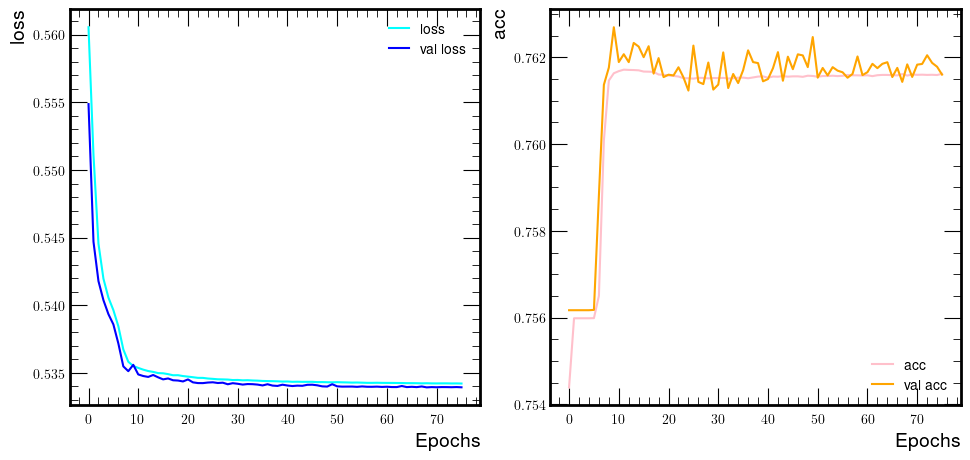

In [57]:
# train neural network
# train() necessary args:
# dctr, callbacks, X_train, Y_train, X_val, Y_val
# train() default args:
# wgt_train=1.0, wgt_val=1.0, epochs=80, batch_size=8192, savePath=currentPath, saveLabel='DCTR_training'):

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*32, saveLabel='DCTR_training')


# load training and predict weights

In [6]:
# load training
dctr, _ = DCTR.setup_nn(input_dim=6, patience=10, saveLabel='DCTR_training')
dctr.load_weights('DCTR_training.h5')

# get reweighting weights
with tf.device('/gpu:0'): # sometimes gave me errors when done on GPU
    weights_0, weights_1 = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*16)


73/73 [==============================] - 2s 19ms/step


In [7]:
## bin reweighting

In [8]:
from hep_ml.reweight import BinsReweighter

bin_reweighter = BinsReweighter(n_bins=31, n_neighs=2)

bin_reweighter.fit(original=X0_test[:,0,0], target=X1_test[:,0,:2],
               original_weight=X0_nrm_wgt, target_weight=X1_nrm_wgt)


BinsReweighter(n_bins=31, n_neighs=3)

In [9]:
bin_rwgt = bin_reweighter.predict_weights(X0_test[:,0,:2], original_weight=X0_nrm_wgt)
bin_rwgt /= np.mean(bin_rwgt) # adjust so that mean is 1


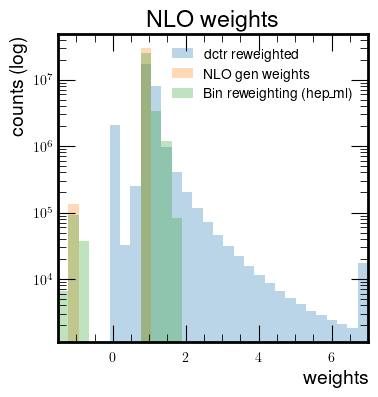

In [22]:
wgt_args = [(weights_0, 'dctr reweighted'),
            (X0_nrm_wgt, 'NLO gen weights'),
            (bin_rwgt, 'Bin reweighting (hep_ml)')]

DCTR.plot_weights(wgt_args, title='NLO weights', stop = 7)


# check and plot DCTR predictions

In [11]:
def delta_phi(X):
    phi_t = X[:,1, 2] # phi of top quark
    phi_t_bar = X[:,2, 2] # phi of anti-top quark
    delta = phi_t - phi_t_bar
    # remap delta from [-2*pi, 2*pi] to [0, 2pi]
    delta = ((delta + 2*math.pi) % (2*math.pi))
    # remap to [0, pi] since it is symmetrical
    delta = math.pi - abs(delta-math.pi)
    
    return delta


In [12]:
X0_delta_phi = delta_phi(X0_test)
X1_delta_phi = delta_phi(X1_test)


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 13121.62587132097 
 chi square of 5029.022045242504 with p 0.0 
 compared to NNLO
NLO reweighted: 
 Mean Absolute Error 949.0294270833333 
 chi square of 35.09464631222616 with p 0.20144870767826403 
 compared to NNLO


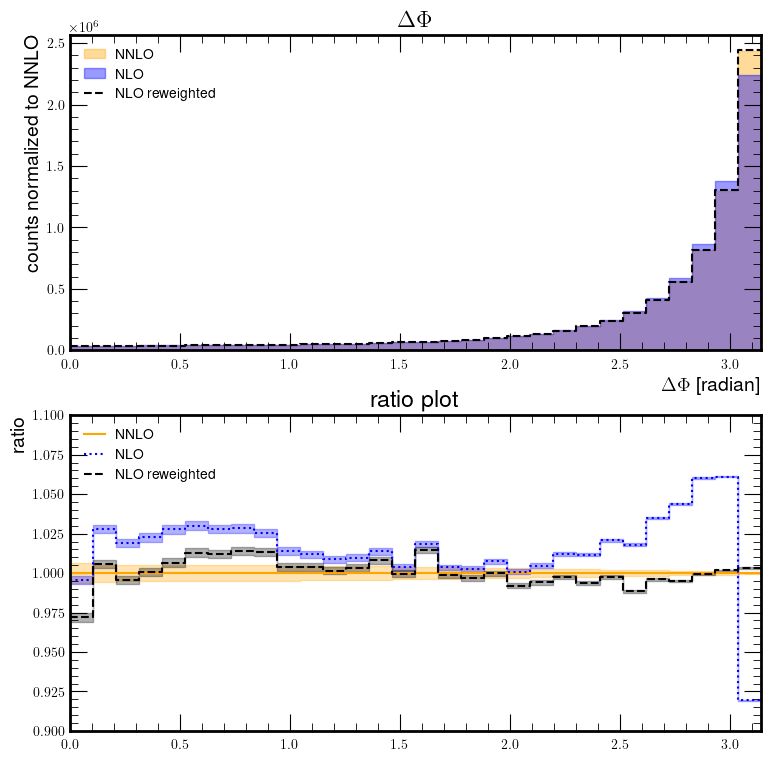

([0.0, 13121.62587132097, 949.0294270833333],
 [0.0, 5029.022045242504, 35.09464631222616],
 [1.0, 0.0, 0.20144870767826403])

In [13]:
args_phi = [(X1_delta_phi, X1_nrm_wgt, 'NNLO'),
        (X0_delta_phi, X0_nrm_wgt, 'NLO'),
        (X0_delta_phi, weights_0, 'NLO reweighted')]

DCTR.plot_ratio(args_phi, title = r'$\Delta \Phi$', x_label = r'$\Delta \Phi$ [radian]', start = 0, stop = math.pi, div = 31)


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 13121.62587132097 
 chi square of 5029.022045242504 with p 0.0 
 compared to NNLO
neural rwt: 
 Mean Absolute Error 949.0294270833333 
 chi square of 35.09464631222616 with p 0.20144870767826403 
 compared to NNLO
bin rwgt: 
 Mean Absolute Error 4342.359850123655 
 chi square of 665.5897084085212 with p 1.488933728719711e-121 
 compared to NNLO


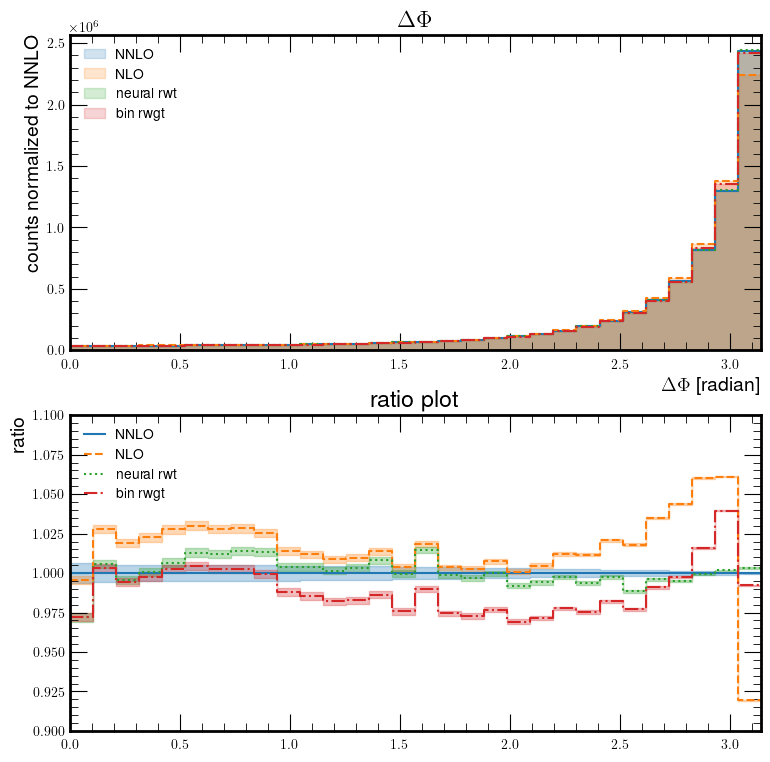

([0.0, 13121.62587132097, 949.0294270833333, 4342.359850123655],
 [0.0, 5029.022045242504, 35.09464631222616, 665.5897084085212],
 [1.0, 0.0, 0.20144870767826403, 1.488933728719711e-121])

In [16]:
args_phi = [(X1_delta_phi, X1_nrm_wgt, 'NNLO'),
            (X0_delta_phi, X0_nrm_wgt, 'NLO'),
            (X0_delta_phi, weights_0, 'neural rwt'),
            (X0_delta_phi, bin_rwgt, 'bin rwgt')]

DCTR.plot_ratio(args_phi, title = r'$\Delta \Phi$', x_label = r'$\Delta \Phi$ [radian]', start = 0, stop = math.pi, div = 31)


In [23]:
args = [(X1_test, X1_nrm_wgt, 'NNLO'),
        (X0_test, X0_nrm_wgt, 'NLO'),
        (X0_test, weights_0, 'dctr reweighted'),
        (X0_test, bin_rwgt, 'bin reweighted')]


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 23788.22193765147 
 chi square of 19519.687020355334 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 888.05830078125 
 chi square of 20.723900084658595 with p 0.8690082795848932 
 compared to NNLO
bin reweighted: 
 Mean Absolute Error 4824.9817878485155 
 chi square of 721.5366697005679 with p 3.1328086048132076e-133 
 compared to NNLO


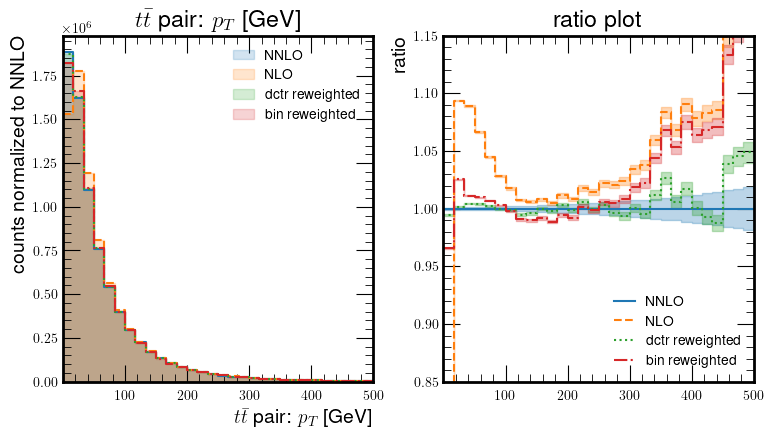

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 13841.73451899574 
 chi square of 5329.6241709901315 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 708.1127477010091 
 chi square of 25.342197046558223 with p 0.6603753515075904 
 compared to NNLO
bin reweighted: 
 Mean Absolute Error 2274.2683186702407 
 chi square of 444.185209281383 with p 7.731289534497061e-76 
 compared to NNLO


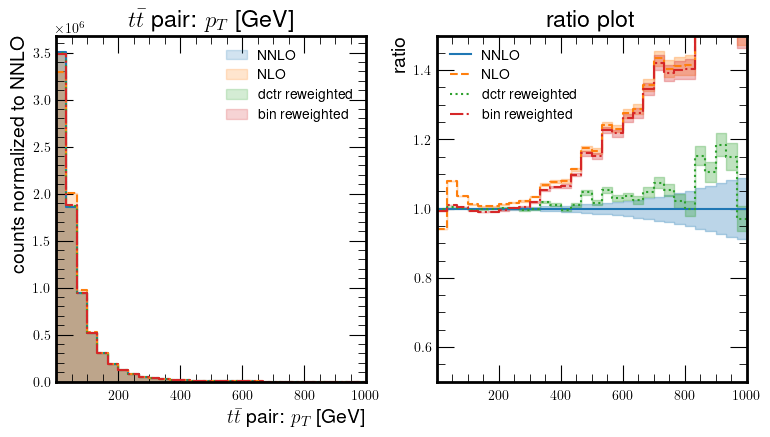

([0.0, 13841.73451899574, 708.1127477010091, 2274.2683186702407],
 [0.0, 5329.6241709901315, 25.342197046558223, 444.185209281383],
 [1.0, 0.0, 0.6603753515075904, 7.731289534497061e-76])

In [15]:
# pt
DCTR.plot_ratio(args, part_index=0, arg_index = 0, stop=500, div = 31, ratio_ylim=[0.85, 1.15], figsize=(8,4.5), layout='cols')

DCTR.plot_ratio(args, part_index=0, arg_index = 0, stop=1000, div = 31, ratio_ylim=[0.5, 1.5], figsize=(8,4.5), layout='cols')


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 23788.22193765147 
 chi square of 19519.687020355334 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 888.05830078125 
 chi square of 20.723900084658595 with p 0.8690082795848932 
 compared to NNLO
bin reweighted: 
 Mean Absolute Error 4824.9817878485155 
 chi square of 721.5366697005679 with p 3.1328086048132076e-133 
 compared to NNLO


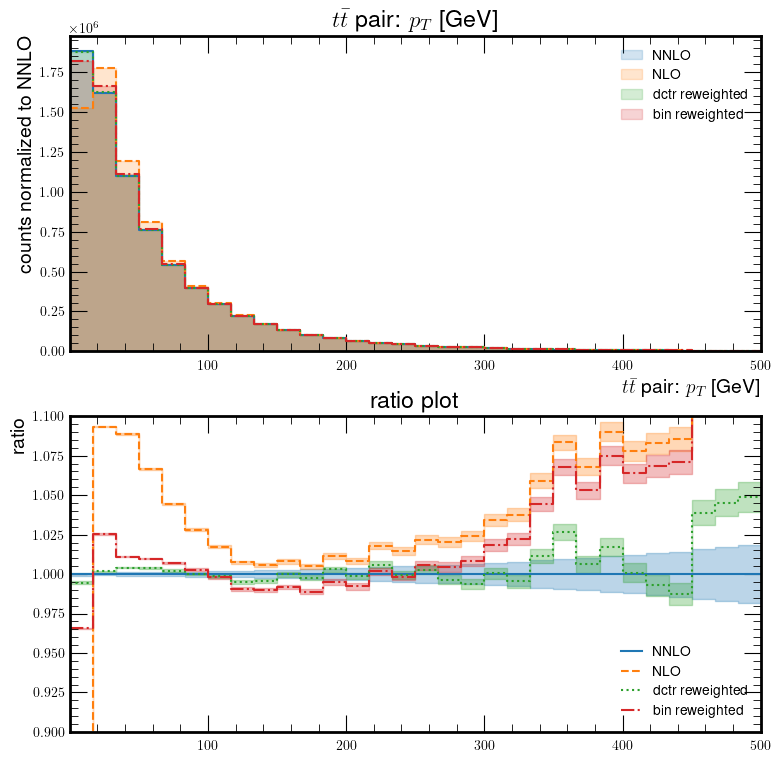

([0.0, 23788.22193765147, 888.05830078125, 4824.9817878485155],
 [0.0, 19519.687020355334, 20.723900084658595, 721.5366697005679],
 [1.0, 0.0, 0.8690082795848932, 3.1328086048132076e-133])

In [16]:
DCTR.plot_ratio(args, part_index=0, arg_index = 0, stop=500, div = 31, ratio_ylim=[0.9, 1.1])


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 5713.056531581832 
 chi square of 1947.2428110535525 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 1504.0292256037394 
 chi square of 93.32151148153997 with p 1.1124785473734754e-08 
 compared to NNLO
bin reweighted: 
 Mean Absolute Error 2969.1016210466105 
 chi square of 1313.862730124728 with p 2.4009839578544152e-258 
 compared to NNLO


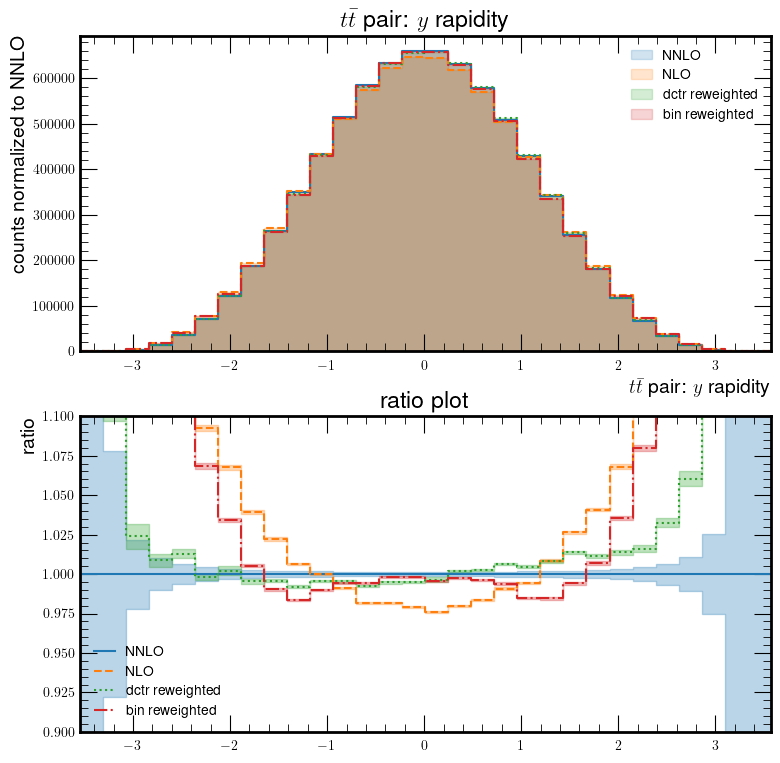

([0.0, 5713.056531581832, 1504.0292256037394, 2969.1016210466105],
 [0.0, 1947.2428110535525, 93.32151148153997, 1313.862730124728],
 [1.0, 0.0, 1.1124785473734754e-08, 2.4009839578544152e-258])

In [17]:
# gamma
DCTR.plot_ratio(args, part_index=0, arg_index = 1, div = 31)


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 3967.352403364831 
 chi square of 547.8417251129083 with p 4.018055799378933e-97 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 607.9121744791667 
 chi square of 11.333198119528737 with p 0.9986588406505553 
 compared to NNLO
bin reweighted: 
 Mean Absolute Error 3296.7556282689998 
 chi square of 382.0247376917239 with p 3.2128754466456145e-63 
 compared to NNLO


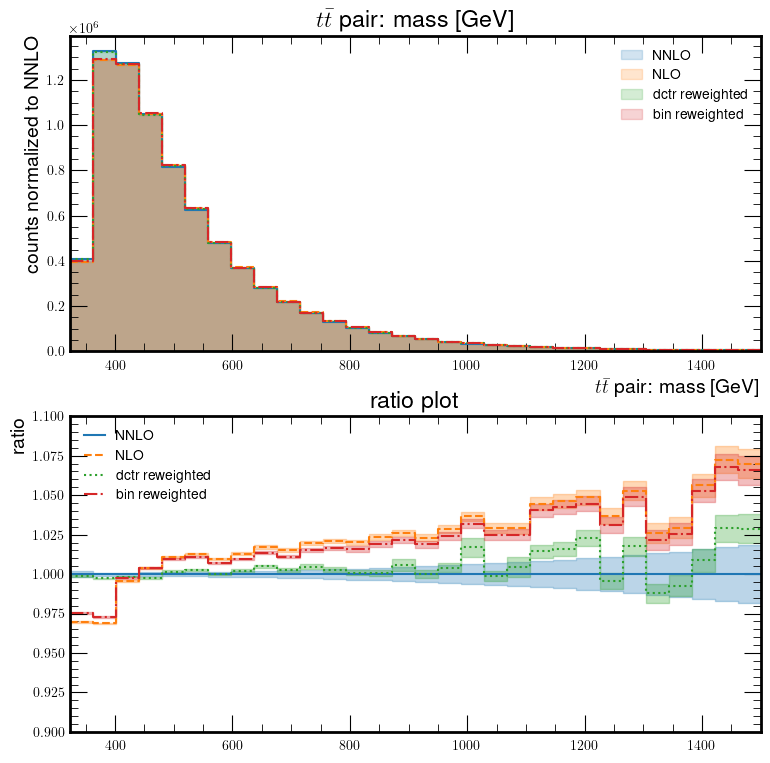

([0.0, 3967.352403364831, 607.9121744791667, 3296.7556282689998],
 [0.0, 547.8417251129083, 11.333198119528737, 382.0247376917239],
 [1.0, 4.018055799378933e-97, 0.9986588406505553, 3.2128754466456145e-63])

In [24]:
# mass
DCTR.plot_ratio(args, part_index=0, arg_index = 3, div = 31, stop = 1500)


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 17356.757960783263 
 chi square of 11171.280295288676 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 789.2211303710938 
 chi square of 28.548378743334784 with p 0.6885002612770724 
 compared to NNLO


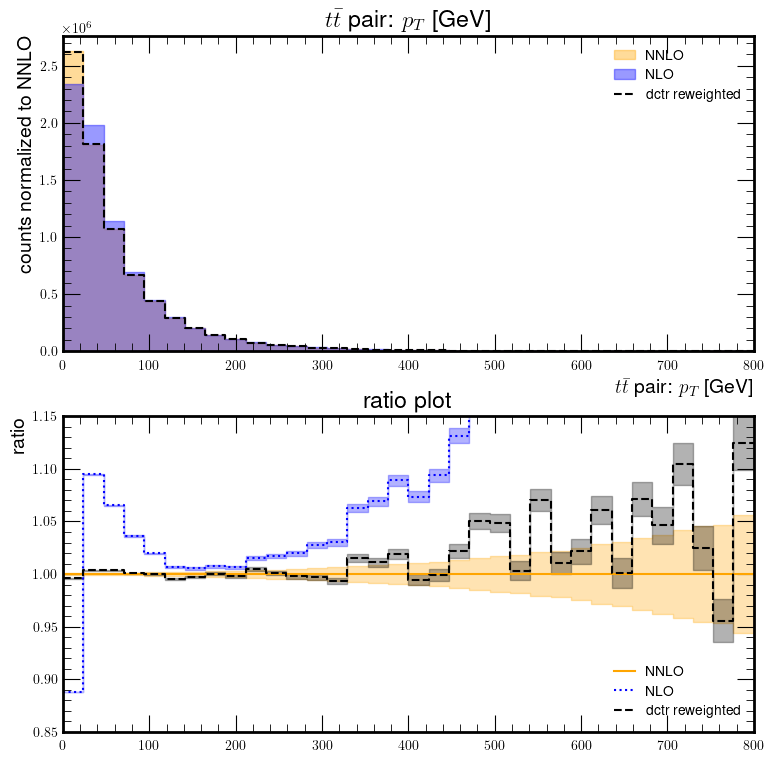

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 5005.462388576758 
 chi square of 1964.4592610736688 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 1348.0224406298469 
 chi square of 96.22329707391759 with p 4.247862376322809e-08 
 compared to NNLO


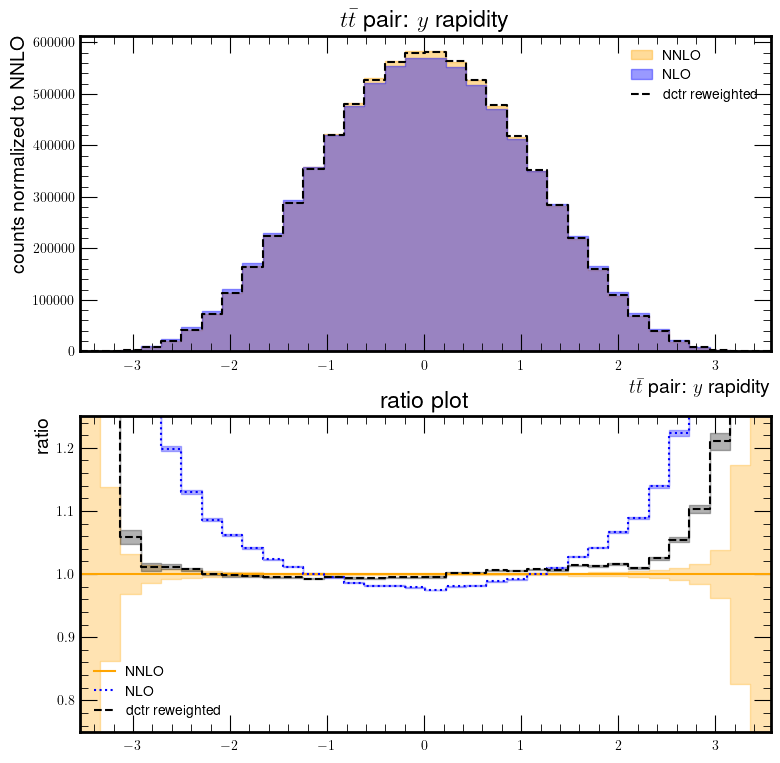

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 3561.3020600962486 
 chi square of 596.9536699880643 with p 1.101999620261956e-104 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 578.1659079159008 
 chi square of 14.513104752921073 with p 0.9978092452794673 
 compared to NNLO


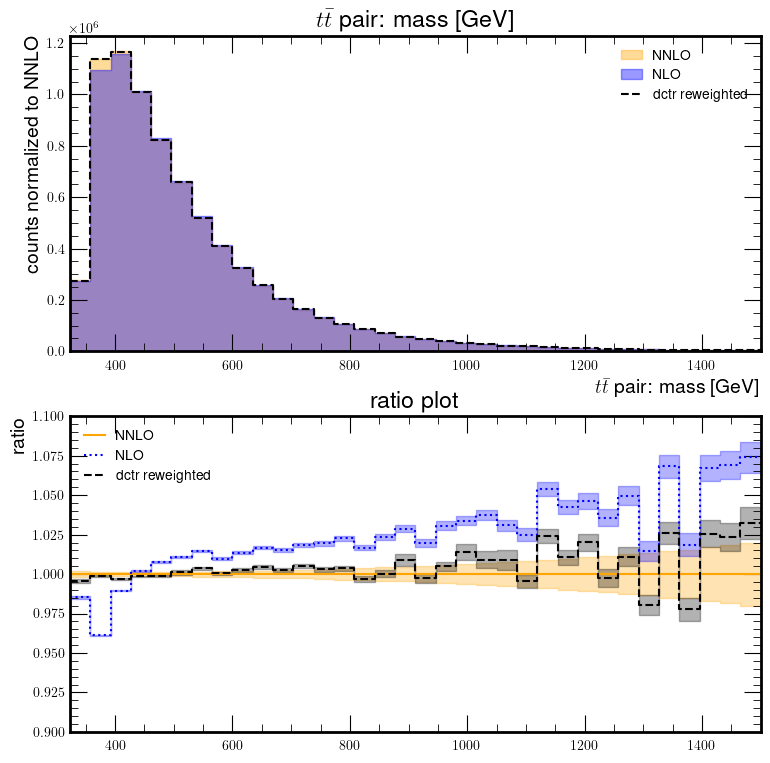

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 11402.29105536934 
 chi square of 14899.331980291878 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 1490.2826484231389 
 chi square of 99.15550951561623 with p 1.5414079233397222e-08 
 compared to NNLO


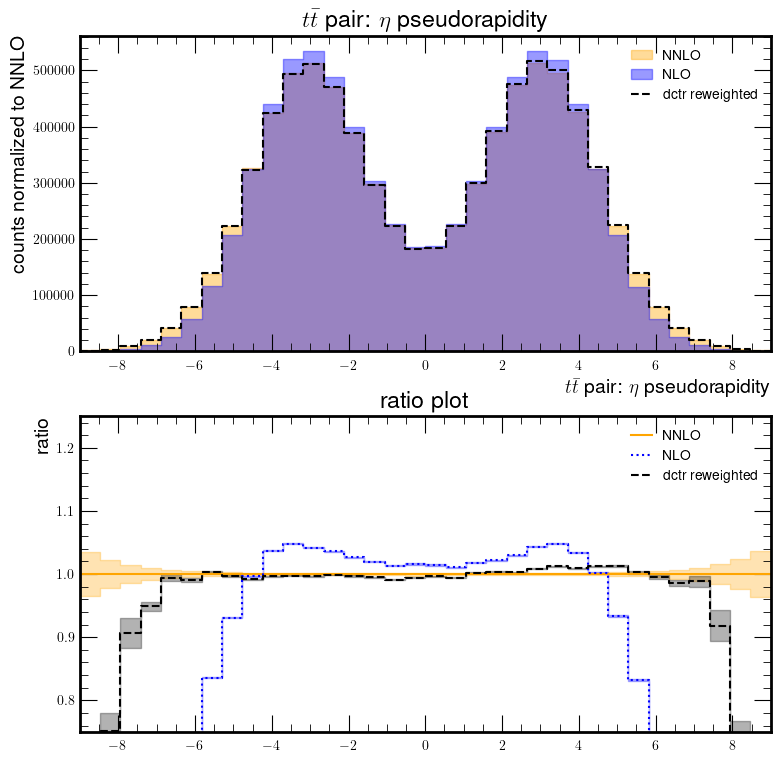

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 5346.203692356578 
 chi square of 1736.0471821793112 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 803.7299230238971 
 chi square of 30.45442209314731 with p 0.5944724157933369 
 compared to NNLO


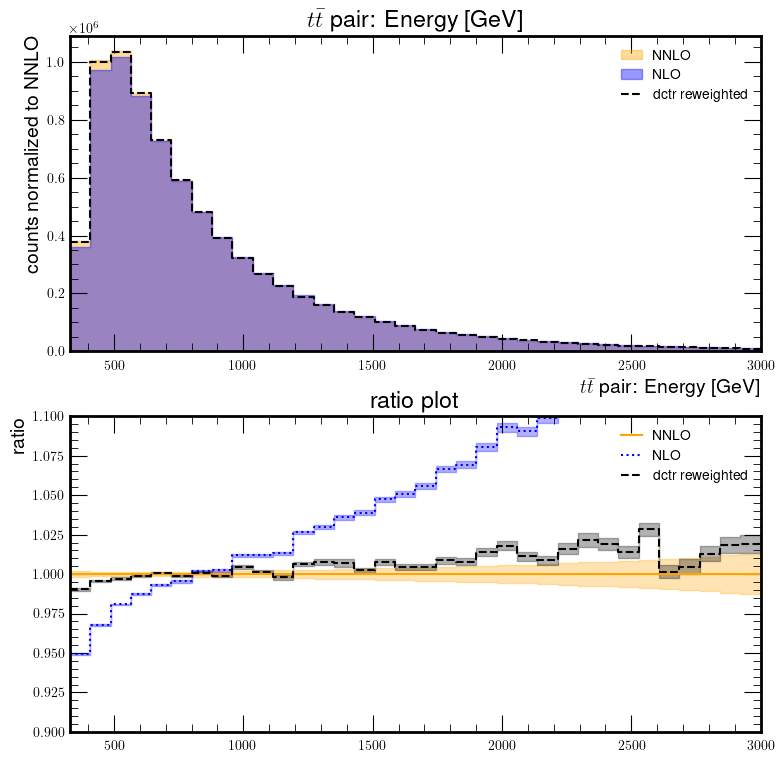

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 6690.758478531883 
 chi square of 2083.5030807715834 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 686.0665902530445 
 chi square of 21.922830490927335 with p 0.9293033023502402 
 compared to NNLO


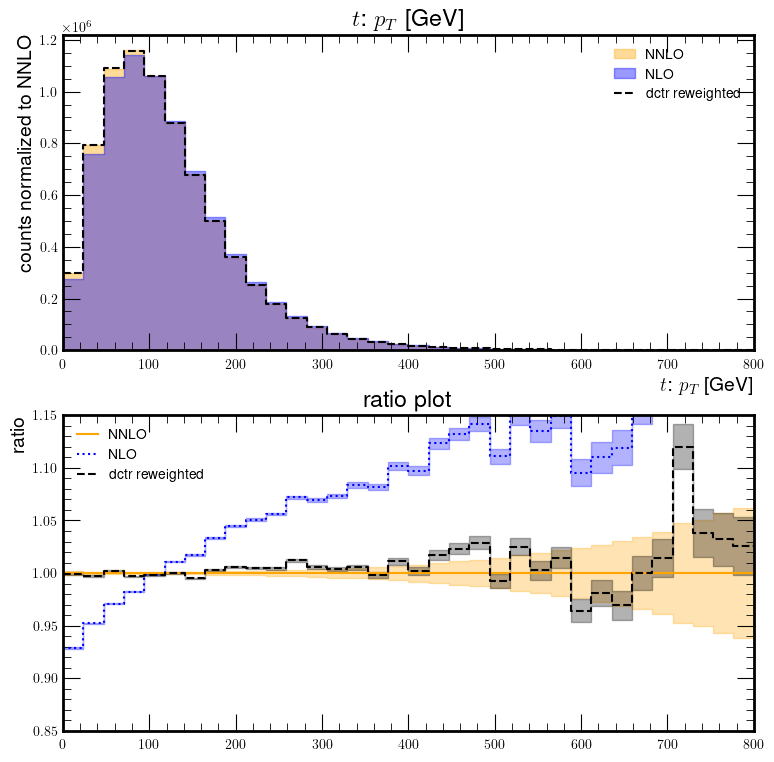

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 3134.2297412811454 
 chi square of 919.3182567109374 with p 8.710225256664687e-172 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 1050.8305698563072 
 chi square of 68.56587327812251 with p 0.0002722430914705805 
 compared to NNLO


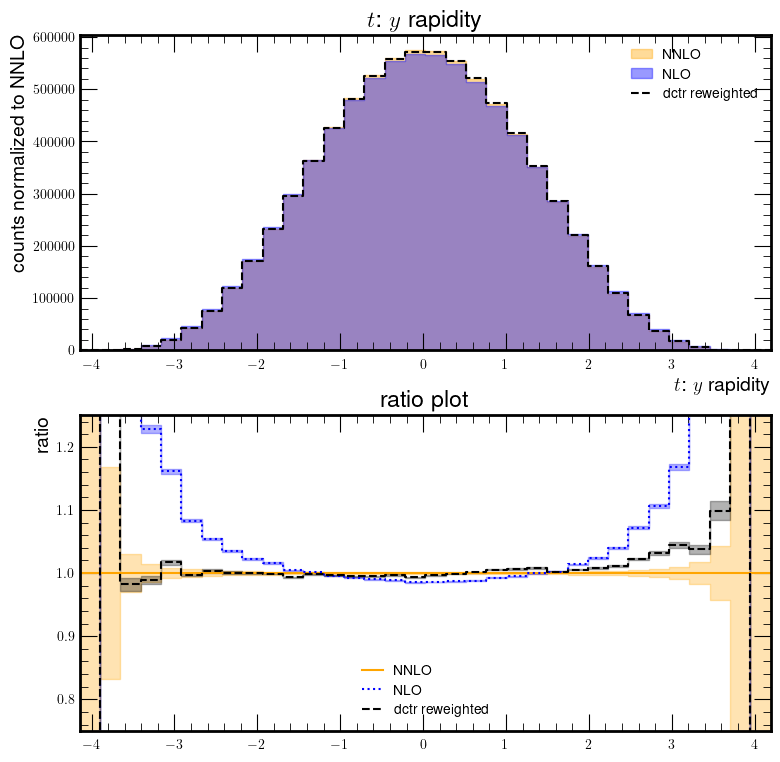

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 7624.682059055961 
 chi square of 8820.310089123677 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 542.4093663832721 
 chi square of 68.13587386051036 with p 0.0003075511487935373 
 compared to NNLO


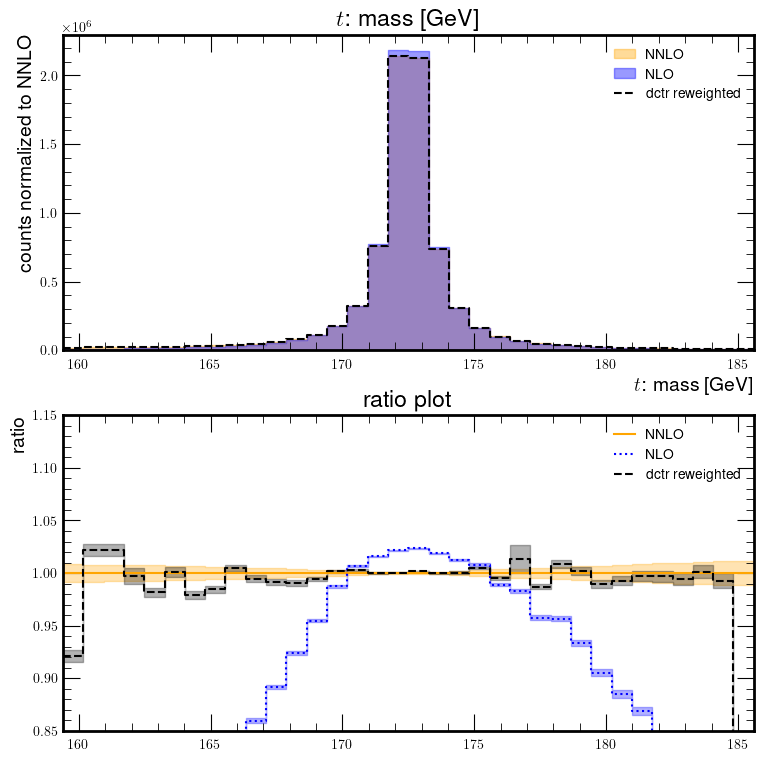

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 561.7017192934396 
 chi square of 23.61749168836668 with p 0.8854744402870537 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 1112.8319469339708 
 chi square of 42.59314849195405 with p 0.12242361285585664 
 compared to NNLO


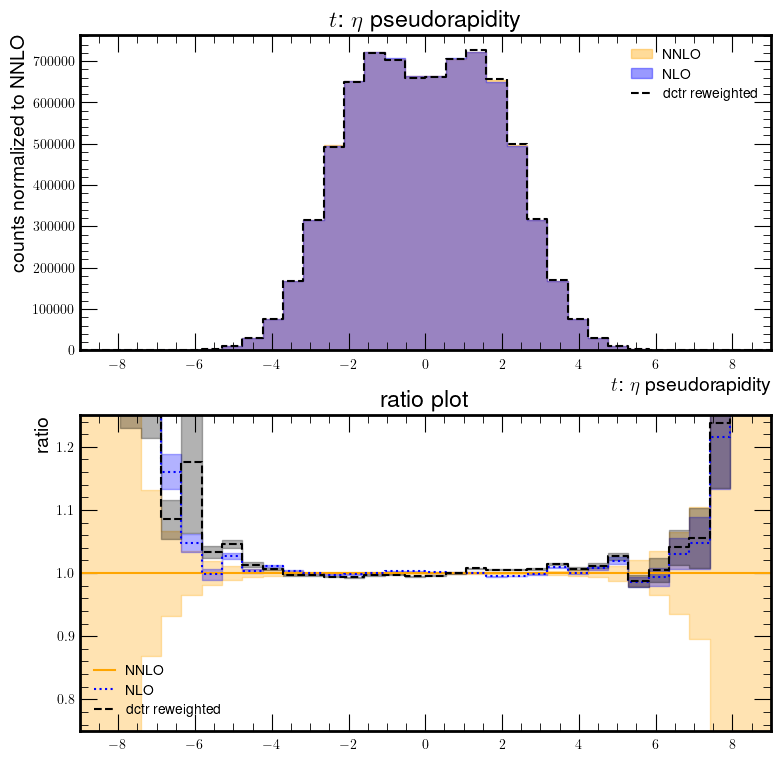

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 4879.783699049658 
 chi square of 1255.9216787068844 with p 8.784083176780948e-243 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 701.1269387637867 
 chi square of 21.572936736642372 with p 0.9367039928794367 
 compared to NNLO


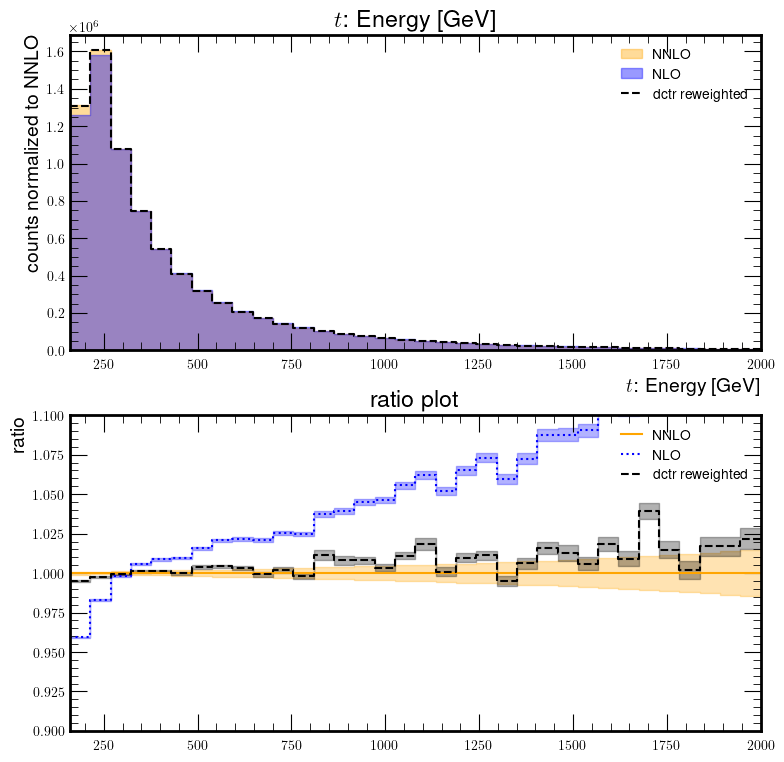

In [19]:
args = [(X1_test, X1_nrm_wgt, 'NNLO'),
        (X0_test, X0_nrm_wgt, 'NLO'),
        (X0_test, weights_0, 'dctr reweighted')]

arg_indices = [0, 1, 3, 4, 5]
part_indices = [0, 1]
div = 31

mae_all = []
chi2_all = []
p_all = []

for part_index in part_indices:
    for arg_index in arg_indices:
        bins = []
        ratio_ylim = [0.75, 1.25]
        if arg_index == 1:  # rapidity
            start = None
            stop = None
        elif arg_index == 3:  # mass
            if part_index == 0:  # tt-pair
                start = None
                stop = 1500
                ratio_ylim = [0.90, 1.10]
            else:
                start = None
                stop = None
                ratio_ylim = [0.85, 1.15]
        elif arg_index == 4:  # pseudorapidity
            start = -9
            stop = 9
        elif arg_index == 5: # energy
            ratio_ylim = [0.9, 1.10]
            if part_index == 0:  # tt-pair
                start = None
                stop = 3000
            else:
                start = None
                stop = 2000
        else:  # pt
            ratio_ylim = [0.8, 1.2]
            start = 0
            stop = 1000
        
        mae_list, chi2_list, p_list = DCTR.plot_ratio(args, arg_index=arg_index, part_index=part_index, start = start, stop = stop, ratio_ylim = ratio_ylim)
        mae_all.append(mae_list)
        chi2_all.append(chi2_list)
        p_all.append(p_list)


In [20]:
mae_mean = np.mean(mae_all, axis = 0)
chi2_mean = np.mean(chi2_all, axis = 0)
p_mean = np.mean(p_all, axis = 0)

print('[NNLO, NLO, NLR rwgt]')
print(f'MAE  mean: {mae_mean}\n')
print(f'chi2 mean: {chi2_mean}\n')
print(f'p    mean: {p_mean}\n')


[NNLO, NLO, NLR rwgt]
MAE  mean: [   0.         6556.31728544  910.26874626]

chi2 mean: [   0.         4347.07429858   49.1685375 ]

p    mean: [1.         0.08854744 0.42697927]



NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 8376.98254914235 
 chi square of 8818.265975317949 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 575.7329574092741 
 chi square of 57.770303731455286 with p 0.0016996545605114316 
 compared to NNLO


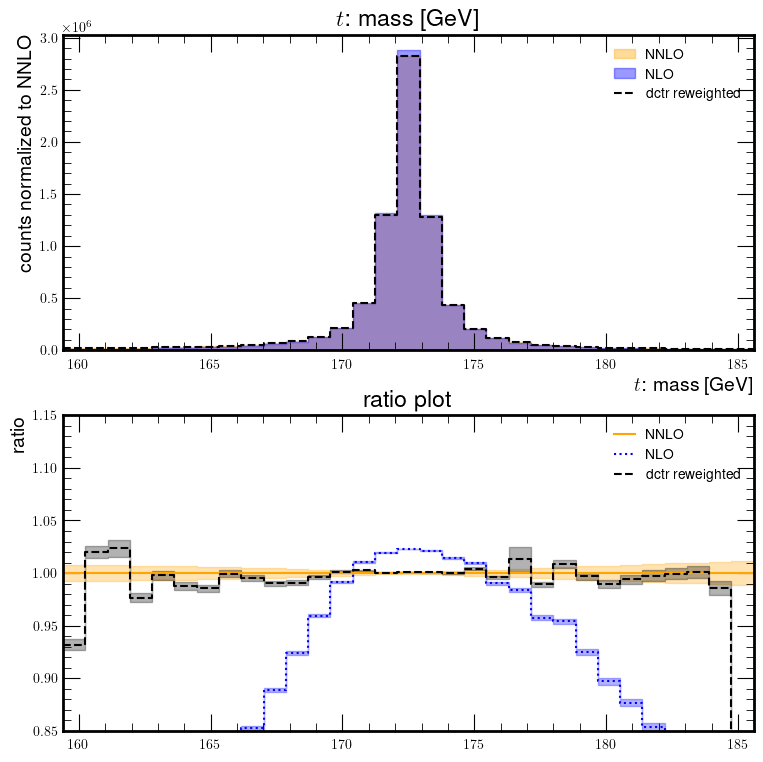

([0.0, 8376.98254914235, 575.7329574092741],
 [0.0, 8818.265975317949, 57.770303731455286],
 [1.0, 0.0, 0.0016996545605114316])

In [27]:
start = None
stop = None
div = 32
ratio_ylim = [0.85, 1.15]

args = [(X1_test, X1_nrm_wgt, 'NNLO'),
        (X0_test, X0_nrm_wgt, 'NLO'),
        (X0_test, weights_0, 'dctr reweighted')]

DCTR.plot_ratio(args, arg_index=3, part_index=1, start = start, stop = stop, div=div, ratio_ylim = ratio_ylim)
